In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from nltk.corpus import stopwords
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

corpus = pd.read_csv('corpus.csv.gz', compression='gzip')
stopwords = stopwords.words("portuguese")
corpus = corpus[corpus['qual_a_melhor_classificao_para_esse_texto:confidence'] == 1]

In [2]:
n_features = 1600
n_topics = 40
n_top_words = 20

In [3]:
def print_top_words(model, feature_names, n_top_words, stats):
    for topic_idx, topic in enumerate(model.components_):
        if stats.significance[topic_idx] <= 0.05:
            print("Topic #%d (%.5f):" % (topic_idx, stats.significance[topic_idx]))
            print(" ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def diff(x): 
    return (x['diario_mean']) - (x['outro_mean'])

In [4]:
from nltk.corpus import floresta
from nltk import DefaultTagger, AffixTagger, UnigramTagger, BigramTagger, TrigramTagger

tagged_sents = floresta.tagged_sents()
t0 = DefaultTagger('H+n') # if word not known, just guess "noun"
affix_tagger = AffixTagger(tagged_sents, backoff=t0)
unigram_tagger = UnigramTagger(tagged_sents, cutoff=0, backoff=affix_tagger)
bigram_tagger = BigramTagger(tagged_sents, cutoff=0, backoff=unigram_tagger)
trigram_tagger = TrigramTagger(tagged_sents, cutoff=0, backoff=bigram_tagger)

In [7]:
import pickle
affix_file = open('portuguese_affix_tagger.pickle', 'wb')
pickle.dump(affix_tagger, affix_file)
affix_file.close()

In [8]:
unigram_file = open('portuguese_unigram_tagger.pickle', 'wb')
pickle.dump(unigram_tagger, unigram_file)
unigram_file.close()

In [9]:
bigram_file = open('portuguese_bigram_tagger.pickle', 'wb')
pickle.dump(bigram_tagger, bigram_file)
bigram_file.close()

In [10]:
trigram_file = open('portuguese_trigram_tagger.pickle', 'wb')
pickle.dump(trigram_tagger, trigram_file)
trigram_file.close()

In [13]:
with open('portuguese_affix_tagger.pickle', 'rb') as f: affix_tagger = pickle.load(f)
with open('portuguese_unigram_tagger.pickle', 'rb') as f: unigram_tagger = pickle.load(f)
with open('portuguese_bigram_tagger.pickle', 'rb') as f: bigram_tagger = pickle.load(f)
with open('portuguese_trigram_tagger.pickle', 'rb') as f: trigram_tagger = pickle.load(f)

In [50]:
from nltk import tokenize

def simplify_tag(t):
    if t and "+" in t:
        return t[t.index("+")+1:]
    else:
        return t

def content_words(x):
    #Nouns, verbs, adjectives and adverbs 
    tags = trigram_tagger.tag(tokenize.word_tokenize(x['content']))
    tags = [(w ,simplify_tag(t)) for (w,t) in tags]

    words = []
    for (word, tag) in tags:
        if tag in ['adj','v-fin','n']:
          words.append(word)

    return ' '.join(words)

corpus['content_words'] = corpus.apply(content_words,axis=1)

In [51]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, strip_accents='unicode',
                                   max_features=n_features,
                                   stop_words=stopwords)
tfidf = tfidf_vectorizer.fit_transform(corpus.content_words)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, strip_accents='unicode',
                                max_features=n_features,
                                stop_words=stopwords)
tf = tf_vectorizer.fit_transform(corpus.content_words)

In [55]:
n_topics = 40
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
data = lda.fit_transform(tf)

topics = pd.DataFrame(data, columns=range(0,n_topics))

topics['labels'] = corpus['labels'].values
topics['class'] = corpus['qual_a_melhor_classificao_para_esse_texto'].values
outro_topics = topics[topics['class']=='outro']
diarios_topics = topics[topics['class']=='diario'].sample(len(outro_topics))

significance = []
for column in list(topics.columns.values):
    if str(column).isnumeric():
        a = diarios_topics[column]
        b = outro_topics[column]
        t, p = wilcoxon(a, b)
        significance.append(p)

stats = pd.DataFrame(data={'significance': significance}, index=range(0,n_topics))

stats['diario_mean'] = diarios_topics.mean(axis=0) * 100
stats['outro_mean'] = outro_topics.mean(axis=0) * 100
stats['diario_std'] = diarios_topics.std(axis=0) * 100
stats['outro_std'] = outro_topics.std(axis=0) * 100

stats['diff'] = stats.apply(diff,axis=1)

size = len(stats[stats['significance'] <= 0.05])
print(str(n_topics) + ' : ' + str(size))

# 35, 38

40 : 37


In [39]:
topics_label = pd.DataFrame(data={'labels': topics.columns.values}, index=topics.columns.values)

for doc in topics.index.values:
    for topic in topics.columns.values:
        if str(topic).isnumeric():
            if topics.values[doc][topic] > 0.5:
                if str(topics_label['labels'][topic]).isnumeric():
                    topics_label['labels'][topic] = list()
                topics_label['labels'][topic].append(corpus['labels'].values[doc])

In [40]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words, stats)

Topic #0 (0.00397):
pos cinema loja melhor dente nestle kit chao cultural entrevista basico inverno produto 2009 aprendi diria mundo ansiedade dizia azul
Topic #1 (0.00191):
nao cm dente mr pq impossivel policial to pare kg talento momento banheiro vai desenhos sinal vou desenho artista advogado
Topic #2 (0.00397):
vai nao sozinha quero album musicas disse acho entrevista disco proximo producao grande mail membros casa verao perguntei expectativas rotina
Topic #3 (0.00703):
comunidade link comunidades nao fara concurso tempo gente existem etapa agora vai nova bem onde ainda coisas conta vida cara
Topic #4 (0.00397):
senhor sao morte dia ceu medo gente solidao presenca ultimo memoria festa dias pessoas momentos jeito ali meio labios ultimos
Topic #6 (0.04735):
video faixa cantora amy gravacao setembro musica completo album soube faria estara conheci 2011 filha chega voce chama traz versao
Topic #9 (0.03749):
the you of to go is it now in my your all this on cd musica night we banda tris

In [41]:
stats[stats['significance'] <= 0.05]

,significance,diario_mean,outro_mean,diario_std,outro_std,diff
0,0.003968,0.048359,0.029864,0.179799,0.026857,0.018495
1,0.001911,1.490866,0.710214,10.210027,6.989977,0.780652
2,0.003968,0.048359,0.029864,0.179799,0.026857,0.018495
3,0.007035,0.117404,0.321675,0.972760,2.355038,-0.204271
4,0.003968,0.048359,0.029864,0.179799,0.026857,0.018495
6,0.047352,0.048359,1.328654,0.179799,9.539043,-1.280295
9,0.037487,0.772189,1.323356,7.153584,8.294649,-0.551167
10,0.003968,0.048359,0.029864,0.179799,0.026857,0.018495
11,0.003968,0.048359,0.029864,0.179799,0.026857,0.018495
12,0.003968,0.048359,0.029864,0.179799,0.026857,0.018495


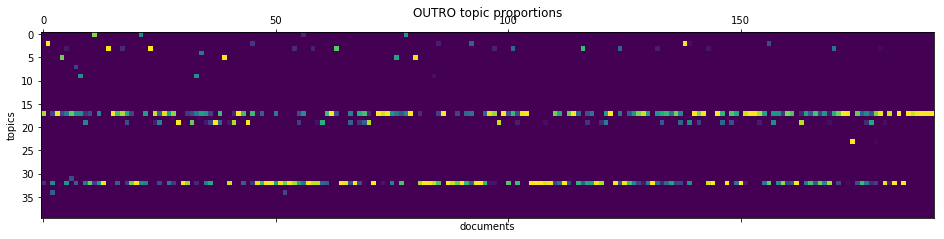

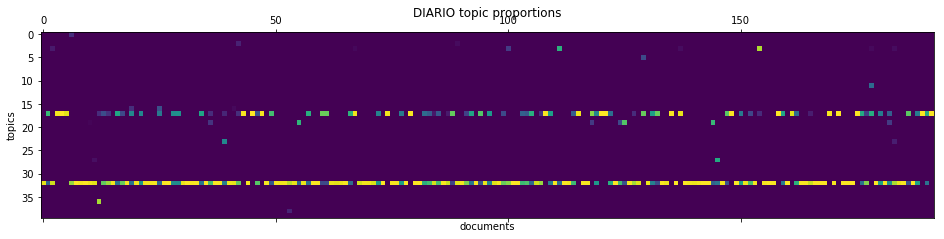

In [58]:
%matplotlib inline
drop_list = ['class','labels']

outro_plot = outro_topics.drop(drop_list, axis=1).values
plt.figure()
plt.matshow(np.transpose(outro_plot))   
plt.gca().set_aspect('auto')
plt.title('OUTRO topic proportions')
plt.ylabel('topics')
plt.xlabel('documents')
plt.show()

diario_plot = diarios_topics.drop(drop_list, axis=1).values
plt.figure()
plt.matshow(np.transpose(diario_plot))   
plt.gca().set_aspect('auto')
plt.title('DIARIO topic proportions')
plt.ylabel('topics')
plt.xlabel('documents')
plt.show()